In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import mne
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

# Cargar datos desde el archivo .mat
mat_data = loadmat('emptyEEG.mat')
eeg_data = mat_data['EEG'][0, 0]
lf_data = mat_data['lf'][0, 0]
srate_value = eeg_data['srate'][0, 0]

# Obtener posiciones de electrodos desde `chanlocs`
chanlocs = eeg_data['chanlocs'][0]
ch_pos = {}
for loc in chanlocs:
    label = loc['labels'][0]  # Nombre del electrodo
    x = float(loc['X'][0][0])  # Coordenada X
    y = float(loc['Y'][0][0])  # Coordenada Y
    z = float(loc['Z'][0][0])  # Coordenada Z
    ch_pos[label] = [x, y, z]

# Crear la estructura de información de los electrodos
info = mne.create_info(ch_names=list(ch_pos.keys()), sfreq=srate_value, ch_types="eeg")
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info.set_montage(montage)

# Proyecciones de los dipolos 109 y 409
dipolo_indices = [1000 - 1, 40 - 1]  # Ajuste de índice para Python

# Crear figura con subgráficas para las proyecciones y el gráfico 3D
fig = plt.figure(figsize=(18, 7))

# Proyección en el cuero cabelludo del dipolo 109
ax1 = fig.add_subplot(1, 3, 1)
gain_projection_109 = -lf_data['Gain'][:, 0, dipolo_indices[0]]
gain_projection_109 = gain_projection_109 / np.max(np.abs(gain_projection_109))  # Normalizar
evoked_109 = mne.EvokedArray(gain_projection_109.reshape(-1, 1), info)
im1, _ = mne.viz.plot_topomap(evoked_109.data[:, 0], evoked_109.info, axes=ax1, contours=0, names=evoked_109.info['ch_names'], cmap='RdBu_r', show=False)
ax1.set_title(f"Proyección del Dipolo {dipolo_indices[0]} en el Cuero Cabelludo")

# Proyección en el cuero cabelludo del dipolo 409
ax2 = fig.add_subplot(1, 3, 2)
gain_projection_409 = -lf_data['Gain'][:, 0, dipolo_indices[1]]
gain_projection_409 = gain_projection_409 / np.max(np.abs(gain_projection_409))  # Normalizar
evoked_409 = mne.EvokedArray(gain_projection_409.reshape(-1, 1), info)
im2, _ = mne.viz.plot_topomap(evoked_409.data[:, 0], evoked_409.info, axes=ax2, contours=0, names=evoked_409.info['ch_names'], cmap='RdBu_r', show=False)
ax2.set_title(f"Proyección del Dipolo {dipolo_indices[1]} en el Cuero Cabelludo")

# Añadir una barra de color compartida con límites consistentes
cbar = fig.colorbar(im1, ax=[ax1, ax2], shrink=0.6, label='Proyección de Actividad')

# Gráfico 3D de las posiciones de los dipolos, resaltando los dipolos 109 y 409
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grid_loc = lf_data['GridLoc']
dipole1_pos = grid_loc[dipolo_indices[0]]
dipole2_pos = grid_loc[dipolo_indices[1]]

# Graficar todos los dipolos
ax3.scatter(grid_loc[:, 0], grid_loc[:, 1], grid_loc[:, 2], c='b', marker='o', label='All Dipoles')
# Graficar los dipolos seleccionados
ax3.scatter(dipole1_pos[0], dipole1_pos[1], dipole1_pos[2], c='g', marker='s', s=400, label=f'Dipole {dipolo_indices[0]} ')
ax3.scatter(dipole2_pos[0], dipole2_pos[1], dipole2_pos[2], c='r', marker='s', s=400, label=f'Dipole {dipolo_indices[1]}')

# Configuración del gráfico 3D
ax3.set_xlabel('X Coordinate')
ax3.set_ylabel('Y Coordinate')
ax3.set_zlabel('Z Coordinate')
ax3.legend()
ax3.set_title('Brain Dipole Locations')

# Mostrar la figura completa con todas las subgráficas
plt.show()

In [4]:
srate_value = eeg_data['srate'][0, 0]
srate_value = np.int32(srate_value)
times_temp = np.arange(-srate_value, 2 * srate_value + 1)
eeg_data['times'] = times_temp / srate_value
eeg_data['pnts'] = np.array([[len(eeg_data['times'])]])
eeg_data['trials'] = 100;

In [5]:
eeg_data['data'] = np.zeros((eeg_data['nbchan'][0, 0], eeg_data['pnts'][0, 0], eeg_data['trials']))
gaus1 = np.exp(-4 * np.log(2) * (eeg_data['times'] - 0.8) ** 2)
gaus2 = np.exp(-4 * np.log(2) * (eeg_data['times'] - 0.9) ** 2 / 0.8)

In [6]:
lf_data = mat_data['lf'][0, 0]

In [7]:
lf_data['Gain'].shape[2]

2004

In [33]:
diploc1 = dipolo_indices[0]
diploc2 = dipolo_indices[1]

for triali in range(eeg_data['trials']):
    # Comienza con actividad aleatoria del dipolo
    dipact = 0.003 * np.random.randn(lf_data['Gain'].shape[2], eeg_data['pnts'][0, 0])
    
    # Dipolo 1
    #freqmod = 5 + 5 * np.interp(np.linspace(1, 10, eeg_data['pnts'][0, 0]), np.arange(1, 11), np.random.rand(10))
    #IFsignal = np.sin(2 * np.pi * ((eeg_data['times'] + np.cumsum(freqmod)) / eeg_data['srate'][0, 0]))
    #dipact[diploc1, :] = IFsignal * gaus1

    # Dipolo 2
    freqmod = 5 + 5 * np.interp(np.linspace(1, 10, eeg_data['pnts'][0, 0]), np.arange(1, 11), np.random.rand(10))
    IFsignal = np.sin(2 * np.pi * ((eeg_data['times'] + np.cumsum(freqmod)) / eeg_data['srate'][0, 0]))
    dipact[diploc2, :] = IFsignal * gaus2

    # Proyecta en el cuero cabelludo
    eeg_data['data'][:, :, triali] = np.squeeze(lf_data['Gain'][:, 0, :]) @ dipact
    
print(eeg_data['data'].shape)

(64, 3073, 100)


Creating RawArray with float64 data, n_channels=64, n_times=307300
    Range : 0 ... 307299 =      0.000 ...   614.598 secs
Ready.


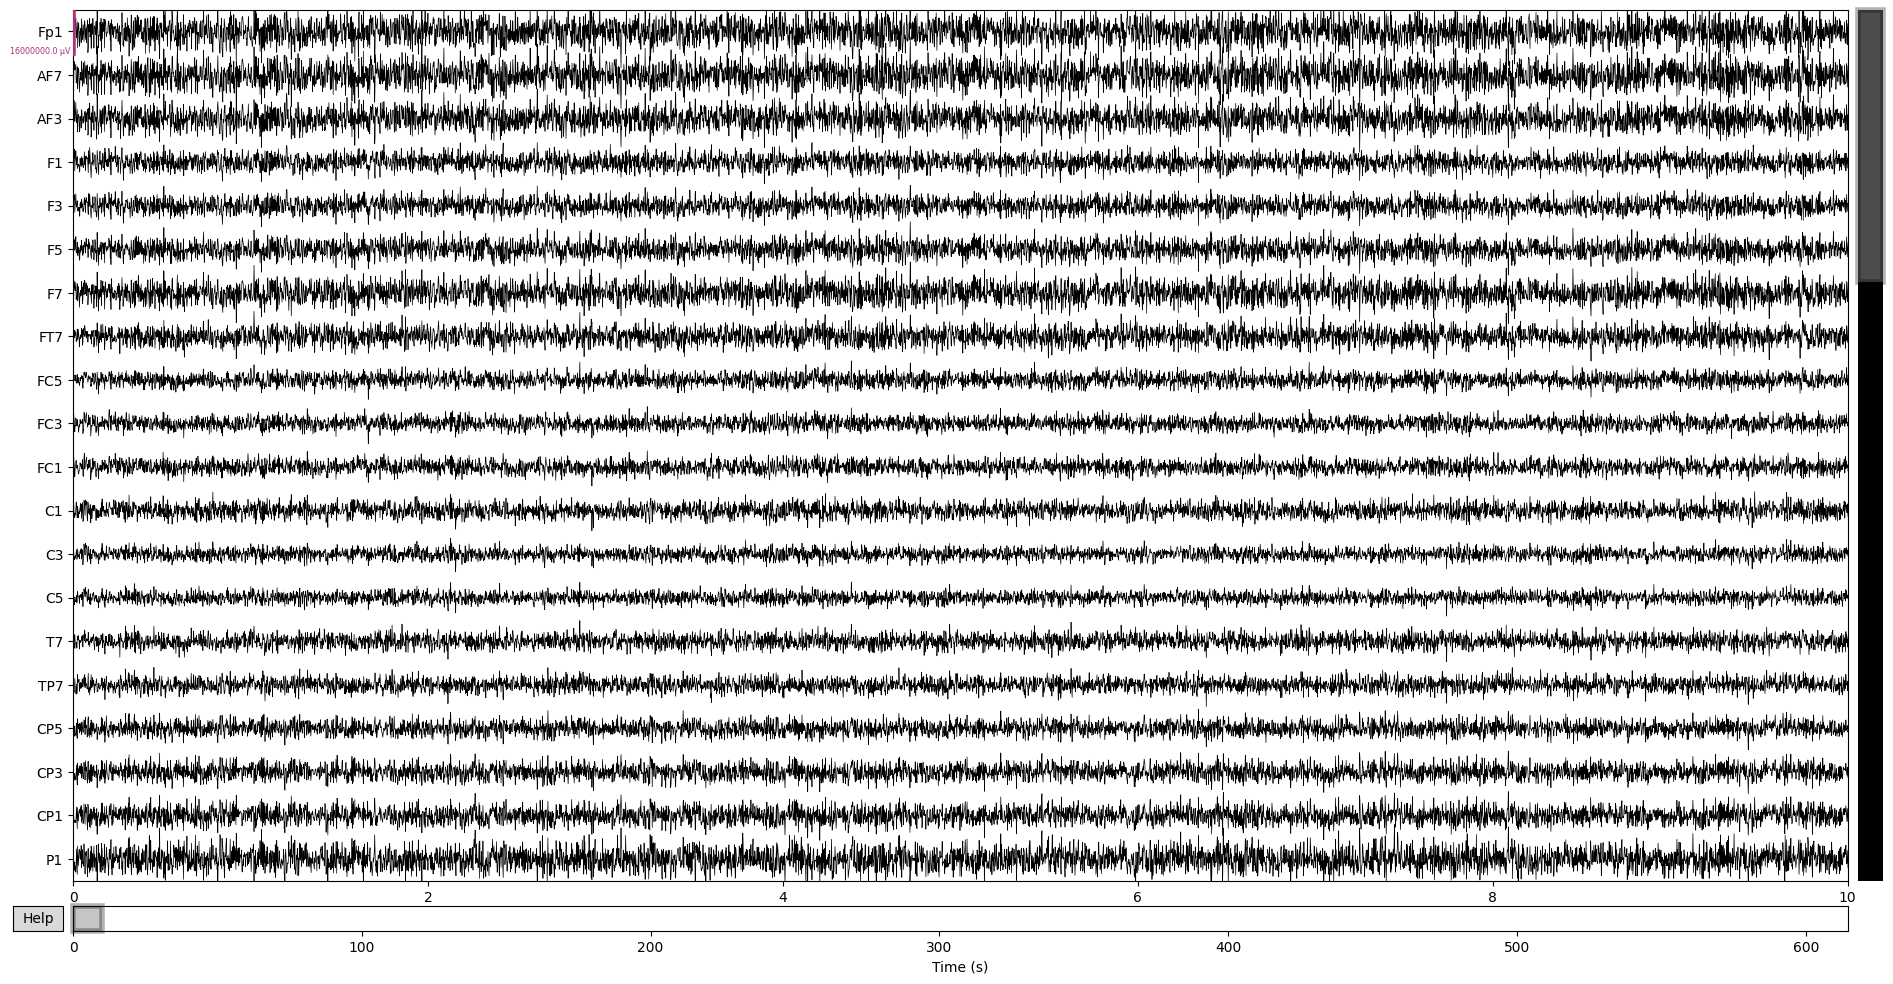

In [35]:
sfreq = srate_value  # Frecuencia de muestreo
n_channels = eeg_data['data'].shape[0]  # 64 canales
ch_names = [f'EEG {i+1}' for i in range(n_channels)]  # Nombres de los canales
ch_types = ['eeg'] * n_channels  # Define todos los canales como EEG

# Reshape los datos para (n_channels, n_times)
data = eeg_data['data'].reshape(n_channels, -1)

chanlocs = eeg_data['chanlocs'][0]
ch_names = [chan['labels'][0] if 'labels' in chan.dtype.names else f'EEG {i+1}' for i, chan in enumerate(chanlocs)]

# Crear RawArray y visualizar
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data, info)
raw.plot(scalings=dict(eeg=80e-1), show=True)

In [10]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Supón que tus datos están en `eeg_data['data']` con la forma (64, 3073, 100)
data = eeg_data['data']  # (canales, puntos, ensayos)

# Promediar los ensayos para obtener una señal promedio
evoked_data = np.mean(data, axis=2)  # Resulta en una forma (64, 3073)

# Extraer los nombres de los canales y las posiciones de `chanlocs`
chanlocs = eeg_data['chanlocs'][0]
ch_names = [loc['labels'][0] for loc in chanlocs]
ch_pos = {}
for loc in chanlocs:
    label = loc['labels'][0]  # Nombre del electrodo
    x = float(loc['X'][0][0])  # Coordenada X
    y = float(loc['Y'][0][0])  # Coordenada Y
    z = float(loc['Z'][0][0])  # Coordenada Z
    ch_pos[label] = [x, y, z]

# Crear información de canales usando `ch_names` y asignar `ch_pos` en el objeto `info`
srate_value = 500  # Frecuencia de muestreo
info = mne.create_info(ch_names=ch_names, sfreq=srate_value, ch_types="eeg")
info.set_montage(mne.channels.make_dig_montage(ch_pos))

# Calcular el promedio total de todas las muestras de tiempo para cada canal
total_average_data = np.mean(evoked_data, axis=1).reshape(-1, 1)

# Crear el objeto Evoked usando los datos promediados y la información de los canales
evoked_total_average = mne.EvokedArray(total_average_data, info)

# Crear una figura con un solo subplot
fig, ax = plt.subplots(figsize=(5, 5))

# Definir la función de actualización para la animación
def update(frame):
    ax.clear()

    # Dibujar el topomap en el subplot con el promedio total
    evoked_total_average.plot_topomap(
        times=[0],  # Usamos 0 porque evoked_total_average solo tiene un punto en el tiempo
        ch_type='eeg',
        size=2,
        extrapolate='head',
        axes=ax,
        show=False,
        colorbar=False,
        sphere=(0.0, 0.0, 0.0, 0.09),
        show_names=True
    )

# Crear la animación
ani = animation.FuncAnimation(fig, update, frames=1, interval=1000, repeat=False)

plt.show()


C:\Users\iemma\AppData\Local\Temp\ipykernel_6480\804327282.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(mne.channels.make_dig_montage(ch_pos))


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Parámetros de los datos
srate = 500  # Frecuencia de muestreo en Hz (asegúrate de usar el valor correcto para tus datos)
channel_fp1 = eeg_data['data'][0, :, 0]  # Selecciona el primer canal y el primer ensayo (ajusta según tus datos)

# Calcular el espectro de potencia usando el método de Welch
frequencies, power = welch(channel_fp1, fs=srate, nperseg=1024)

# Graficar el espectro de potencia
plt.figure(figsize=(10, 4))
plt.plot(frequencies, power)
plt.title("Espectro de Potencia para el Canal Fp1")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Potencia")
plt.show()

# Encontrar la frecuencia dominante
dominant_frequency = frequencies[np.argmax(power)]
print(f"La frecuencia dominante en el canal Fp1 es aproximadamente {dominant_frequency:.2f} Hz")


La frecuencia dominante en el canal Fp1 es aproximadamente 3.91 Hz


In [28]:
# Calcular la potencia espectral
fmin, fmax = 0, 100  # Rango de frecuencia de interés (por ejemplo, alfa)
psds, freqs = mne.time_frequency.psd_array_welch(
    raw.get_data(), sfreq=sfreq, fmin=fmin, fmax=fmax, n_fft=2048, average='mean'
)

# Calcular la potencia media en el rango de frecuencia de interés
psd_mean = psds.mean(axis=-1)

# Crear una figura para los mapas topográficos
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plotear el mapa topográfico
mne.viz.plot_topomap(psd_mean, info, axes=ax, show=True)

Effective window size : 2.000 (s)


(<matplotlib.image.AxesImage at 0x17ed2828da0>,
 <matplotlib.contour.QuadContourSet at 0x17ed1b9cb30>)

In [38]:
# plot_simEEG - plot function for MXC's course on neural time series analysis
# 
# INPUTS:  
#     EEG : eeglab structure (a custom dictionary in this implementation)
#     chan : channel to plot (default = 1)
#   fignum : figure to plot into (default = 1)

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

def plot_simEEG(EEG, chan=1, fignum=1):
    if not EEG:
        raise ValueError("No inputs! Provide the EEG structure to the function.")

    # Create figure and clear it
    plt.figure(fignum, figsize=(10, 8))
    plt.clf()

    ## ERP
    plt.subplot(211)
    plt.title(f'ERP from channel {chan}')
    plt.xlabel('Time (s)')
    plt.ylabel('Activity')
    
    # Plot all trials
    trials = np.squeeze(EEG['data'][chan, :, :])
    h = plt.plot(EEG['times'], trials, linewidth=0.5, color=[0.75, 0.75, 0.75])
    
    # Plot average ERP
    plt.plot(EEG['times'], np.mean(trials, axis=1), 'k', linewidth=3)
    plt.hold = True

    ## Static power spectrum
    hz = np.linspace(0, EEG['srate'], EEG['pnts'])
    if len(EEG['data'].shape) == 3:
        pw = np.mean((2 * np.abs(fft(np.squeeze(EEG['data'][chan, :, :]), axis=0) / EEG['pnts']) ** 2), axis=1)
    else:
        pw = (2 * np.abs(fft(EEG['data'][chan, :]) / EEG['pnts'])) ** 2

    plt.subplot(223)
    plt.plot(hz, pw, linewidth=2)
    plt.xlim([0, 40])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('Static power spectrum')

    ## Time-frequency analysis

    # Frequencies in Hz (hard-coded to 2 to 30 in 40 steps)
    frex = np.linspace(2, 30, 40)

    # Number of wavelet cycles (hard-coded to 3 to 10)
    waves = 2 * (np.linspace(3, 10, len(frex)) / (2 * np.pi * frex)) ** 2

    # Setup wavelet and convolution parameters
    wavet = np.arange(-2, 2, 1 / EEG['srate'])
    halfw = len(wavet) // 2
    nConv = EEG['pnts'] * EEG['trials'] + len(wavet) - 1

    # Initialize time-frequency matrix
    tf = np.zeros((len(frex), EEG['pnts']))

    # Spectrum of data
    dataX = fft(EEG['data'][chan, :, :].reshape(1, -1), nConv)

    # Loop over frequencies
    for fi in range(len(frex)):

        # Create wavelet
        waveX = fft(np.exp(2 * 1j * np.pi * frex[fi] * wavet) * np.exp(-wavet ** 2 / waves[fi]), nConv)
        waveX = waveX / np.max(waveX)  # Normalize

        # Convolve
        asig = ifft(waveX * dataX)

        # Trim and reshape
        asig = asig[0, halfw:-halfw + 1].reshape((EEG['pnts'], EEG['trials']))

        # Power
        tf[fi, :] = np.mean(np.abs(asig), axis=1)

    # Show a map of the time-frequency power
    plt.subplot(224)
    plt.contourf(EEG['times'], frex, tf, 40, cmap='jet')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.title('Time-frequency plot')

    plt.tight_layout()
    plt.show()


In [40]:
import numpy as np

# Define la estructura EEG como un diccionario
EEG = {}
EEG['srate']  = 500  # sampling rate in Hz
EEG['pnts']   = 1500
EEG['trials'] = 30
EEG['nbchan'] = 23

sinefreq = 6.75  # en Hz

# Vector de tiempo
EEG['times'] = np.arange(0, EEG['pnts']) / EEG['srate']

# Inicializar la estructura de datos
EEG['data'] = np.zeros((EEG['nbchan'], EEG['pnts'], EEG['trials']))

# 1) Onda sinusoidal pura con fase bloqueada
for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        EEG['data'][chani, :, triali] = np.sin(2 * np.pi * sinefreq * EEG['times'])



plot_simEEG(EEG, 2, 1)

In [41]:
for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        EEG['data'][chani, :, triali] = np.sin(2 * np.pi * sinefreq * EEG['times'] + 2 * np.pi * np.random.rand())

plot_simEEG(EEG, 2, 2)

In [43]:
frex = [3, 5, 16]
amps = [2, 4, 5]

for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        sinewave = np.zeros(EEG['pnts'])
        for si in range(len(frex)):
            sinewave += amps[si] * np.sin(2 * np.pi * frex[si] * EEG['times'])
        EEG['data'][chani, :, triali] = sinewave
plot_simEEG(EEG, 2, 3)

In [44]:
for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        freqmod = 20 * np.interp(np.linspace(1, 10, EEG['pnts']), np.arange(1, 11), np.random.rand(10))
        signal = np.sin(2 * np.pi * ((EEG['times'] + np.cumsum(freqmod)) / EEG['srate']))
        EEG['data'][chani, :, triali] = signal

plot_simEEG(EEG, 2, 4)

In [45]:
peaktime = 1  # segundos
width = 0.12
sinefreq = 7  # frecuencia del seno

# Crear la envolvente Gaussian
gaus = np.exp(-(EEG['times'] - peaktime) ** 2 / (2 * width ** 2))

for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        cosw = np.cos(2 * np.pi * sinefreq * EEG['times'])
        EEG['data'][chani, :, triali] = cosw * gaus

plot_simEEG(EEG, 2, 5)

In [46]:
for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        sinewave = np.zeros(EEG['pnts'])
        for si in range(len(frex)):
            sinewave += amps[si] * np.sin(2 * np.pi * frex[si] * EEG['times'])
        EEG['data'][chani, :, triali] = sinewave + 5 * np.random.randn(EEG['pnts'])

plot_simEEG(EEG, 2, 6)

In [78]:
noiseamp = 0.3

peaktime = 1  # segundos
width = 0.12
sinefreq = 7  # frecuencia del seno

# Crear la envolvente Gaussian
gaus = np.exp(-(EEG['times'] - peaktime) ** 2 / (2 * width ** 2))

for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        cosw = np.cos(2 * np.pi * sinefreq * EEG['times'] + 2 * np.pi * np.random.rand())

        # Ruido 1/f
        ed = 50
        as_vals = np.random.rand(EEG['pnts'] // 2 - 1) * np.exp(-(np.arange(1, EEG['pnts'] // 2)) / ed)
        as_vals = np.concatenate(([as_vals[0]], as_vals, [0], as_vals[::-1]))

        # Coeficientes de Fourier
        fc = as_vals * np.exp(1j * 2 * np.pi * np.random.rand(len(as_vals)))

        # Transformada inversa de Fourier para crear el ruido
        noise = np.real(np.fft.ifft(fc)) * EEG['pnts']

        # Señal + ruido
        EEG['data'][chani, :, triali] = cosw * gaus + noiseamp * noise

plot_simEEG(EEG, 2, 7)

In [51]:
EEG['data'].shape

(23, 1500, 30)

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Seleccionar el canal
canal_idx = 0  # Cambia este índice al canal que desees

# Extraer los datos para el canal seleccionado
eeg_signals = EEG['data'][canal_idx, :, :]  # Dimensiones: (puntos de tiempo, ensayos)
tiempos = EEG['times'].flatten()

# Graficar todas las señales superpuestas
plt.figure(figsize=(12, 6))

for ensayo_idx in range(eeg_signals.shape[1]):
    plt.plot(tiempos, eeg_signals[:, ensayo_idx], alpha=0.3)

plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (µV)')
plt.title(f'Canal {canal_idx} - Todos los Ensayos Superpuestos')
plt.show()


Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


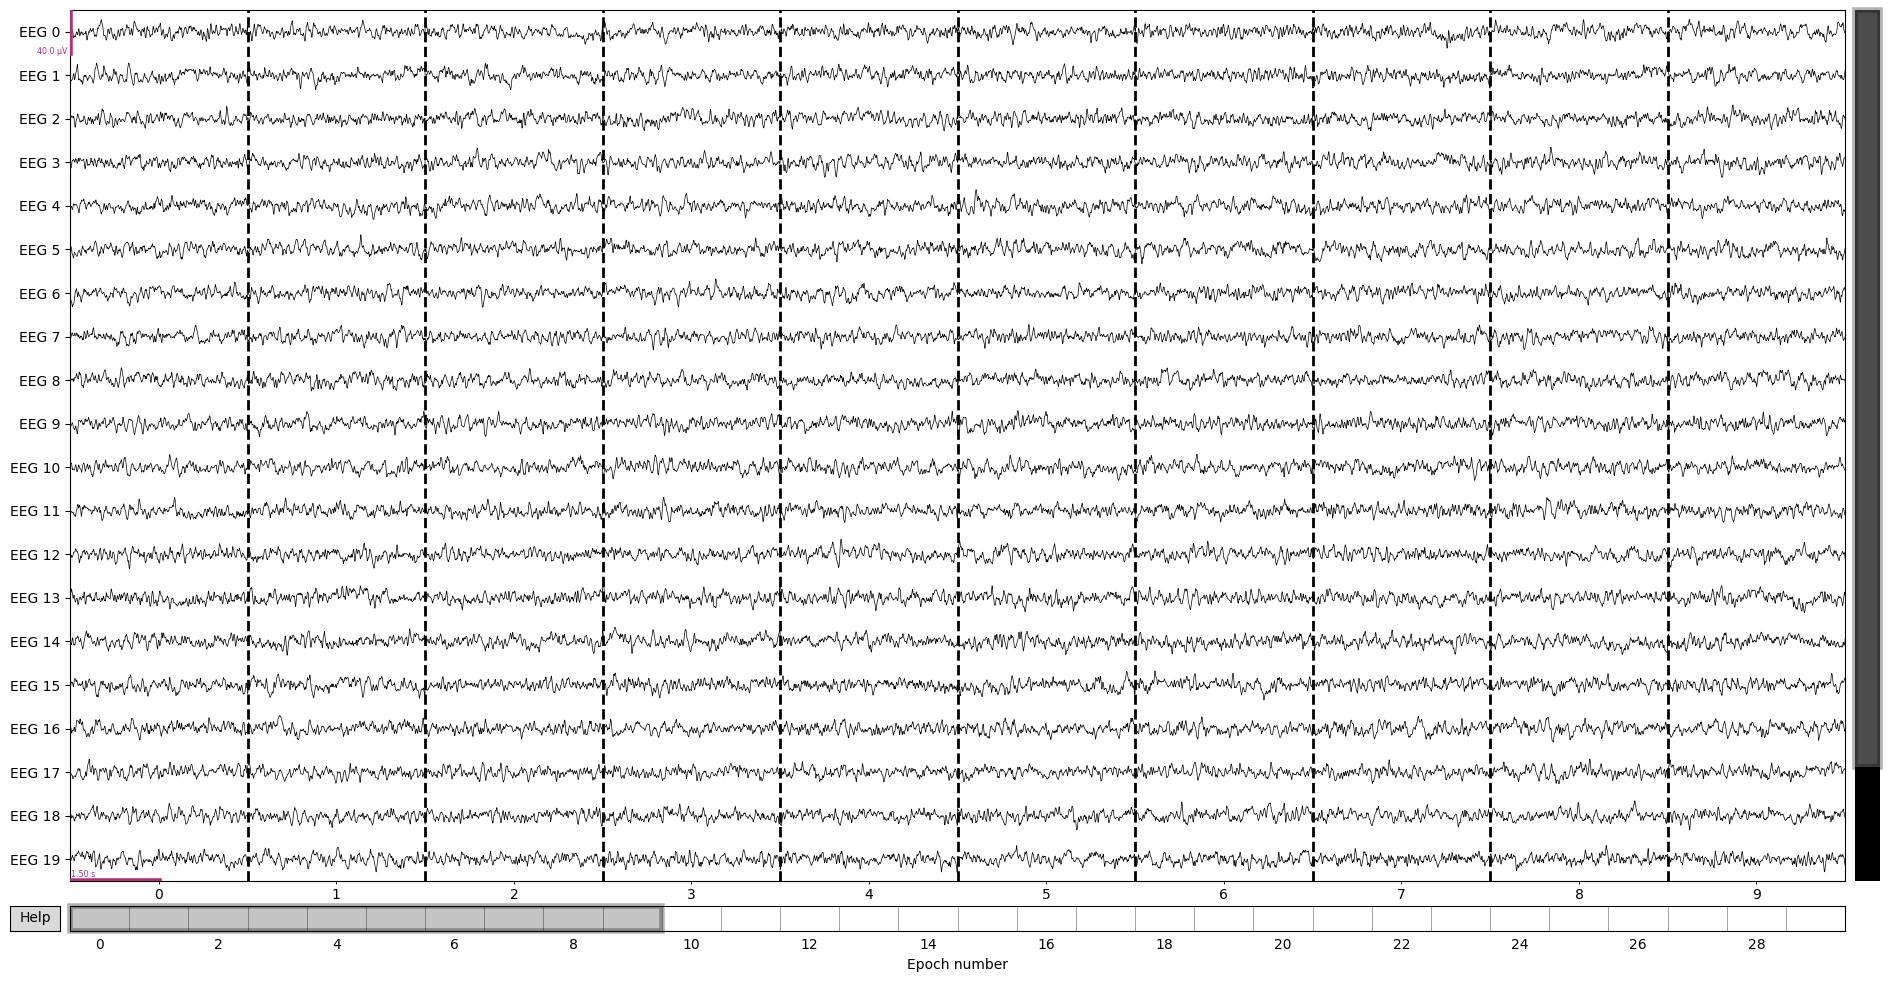

In [81]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Paso 1: Preparar los datos
n_channels = EEG['data'].shape[0]
ch_names = [f'EEG {i}' for i in range(n_channels)]

sfreq = EEG['srate']
if isinstance(sfreq, np.ndarray):
    sfreq = sfreq.item()

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

data = EEG['data']
data = np.transpose(data, (2, 0, 1))
data = data * 0.000004  # Convertir de µV a V

n_epochs = data.shape[0]
events = np.column_stack((np.arange(n_epochs), np.zeros(n_epochs, dtype=int), np.ones(n_epochs, dtype=int)))

epochs = mne.EpochsArray(data, info, events)

# Opción 2: Asignar el montaje estándar ignorando los canales faltantes
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage, on_missing='ignore')

# Paso 3: Continuar con tus visualizaciones
epochs.plot(n_epochs=min(10, n_epochs), picks='eeg')
